# 5.4単純なレイヤの実装

## 乗算,加算レイヤの実装

In [1]:
# coding: utf-8


class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy


class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy



## 実際の計算

In [2]:
# coding: utf-8
from layer_naive import *

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


# 5.51　RELUレイヤ

In [3]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [4]:
import numpy as np
x = np.array([[1.0,-0.5], [-2.0,3.0]])

In [5]:
print(x)

[[ 1.  -0.5]
 [-2.   3. ]]


In [6]:
mask = (x <= 0)

In [7]:
print(mask)

[[False  True]
 [ True False]]


In [8]:
mask = (x>0)

In [9]:
a = np.random.randn(20).reshape(5,4)

In [10]:
a

array([[ 0.68186123, -0.32355821,  1.93456136, -0.67578826],
       [ 0.59308972, -0.34038686,  1.73767686,  0.31745233],
       [ 1.66037327, -1.07196106,  0.86006492,  0.32159425],
       [ 1.10787101, -0.35721309, -0.29051464,  0.87697335],
       [ 0.65222822, -1.54241674,  0.03614391,  0.76581379]])

In [11]:
a > 0

array([[ True, False,  True, False],
       [ True, False,  True,  True],
       [ True, False,  True,  True],
       [ True, False, False,  True],
       [ True, False,  True,  True]])

In [12]:
a = mask  

In [13]:
mask

array([[ True, False],
       [False,  True]])

In [14]:
a[mask] = 10

In [15]:
a

array([[ True, False],
       [False,  True]])

In [16]:
mask

array([[ True, False],
       [False,  True]])

# 5.2  シグモイドレイヤ

In [17]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

# 5.61Affineレイヤ

In [18]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

In [19]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

## 誤差伝播法の実装 

### ニューラルネットワークの実装 

In [20]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

# 5.7.3誤差電波法の勾配確認

* 誤差伝播法のメリットは直接微分を行わず、解析的に数式を解いて勾配を求めるため、効率的に早く計算が可能。
* 数値微分は勾配確認として複雑で実装ミスが起きやすい誤差伝播法の正しさを確認するために用いられる。 

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

## 5.7.4誤差伝播法を使った学習 

In [22]:
%%time
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.12211666666666667 0.1242
0.9001 0.9046
0.9243833333333333 0.9277
0.9361166666666667 0.9363
0.94575 0.9454
0.9521333333333334 0.9513
0.9574166666666667 0.9532
0.96095 0.956
0.9656833333333333 0.9586
0.9679166666666666 0.9613
0.9699833333333333 0.9642
0.9708333333333333 0.964
0.9745 0.9657
0.9742333333333333 0.9657
0.9767166666666667 0.9675
0.9778666666666667 0.9682
0.9781833333333333 0.97
CPU times: user 47.5 s, sys: 9.05 s, total: 56.5 s
Wall time: 41 s


### 勾配法でしてみる 

In [1]:
%%time
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list2 = []
train_acc_list2 = []
test_acc_list2 = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list2.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list2.append(train_acc)
        test_acc_list2.append(test_acc)
        print("train acc2, test acc2 | " + str(train_acc) + ", " + str(test_acc))

train acc2, test acc2 | 0.11016666666666666, 0.1109
train acc2, test acc2 | 0.9049666666666667, 0.9105
train acc2, test acc2 | 0.9239, 0.9264
train acc2, test acc2 | 0.93635, 0.9357
train acc2, test acc2 | 0.9443, 0.9429
train acc2, test acc2 | 0.9481, 0.9431
train acc2, test acc2 | 0.9551333333333333, 0.9521
train acc2, test acc2 | 0.95985, 0.9557
train acc2, test acc2 | 0.9629333333333333, 0.9574
train acc2, test acc2 | 0.9663166666666667, 0.9601
train acc2, test acc2 | 0.9682833333333334, 0.9616
train acc2, test acc2 | 0.9711166666666666, 0.9623
train acc2, test acc2 | 0.9722166666666666, 0.964
train acc2, test acc2 | 0.9732666666666666, 0.9629
train acc2, test acc2 | 0.9754, 0.9662
train acc2, test acc2 | 0.9775, 0.9688
train acc2, test acc2 | 0.9784166666666667, 0.9672
CPU times: user 53.9 s, sys: 9.7 s, total: 1min 3s
Wall time: 52.9 s


In [ ]:
%%time
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 100  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 20
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.numerical_gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc2, test acc2 | " + str(train_acc) + ", " + str(test_acc))

ValueError: x and y must have same first dimension, but have shapes (17,) and (1,)

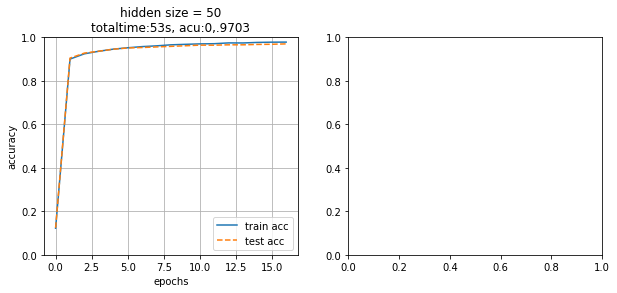

In [24]:
markers = {'train': 'o', 'test': 's'}

plt.figure(figsize=(10, 4))

x = np.arange(len(train_acc_list))
plt.subplot(1,2,1)
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('hidden size = 50\ntotaltime:56.5s, acu:0,.9781')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.savefig("hiddensize5")
plt.grid(True)

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.subplot(1,2,2)
plt.plot(x, train_acc_list2, label='train acc')
plt.plot(x, test_acc_list2, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('hidden size = 50\ntotal:51.5, acu:0.9683')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.savefig("hiddensize50")
plt.grid(True)